In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.linalg as linalg

from haversine import haversine
from tqdm import tqdm
from einops import rearrange
from time import time
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader

project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
if project_dir not in sys.path:
    sys.path.append(project_dir)

from utils.data import load_data
from utils.tool import prediction_summary

c:\Users\d5233\anaconda3\envs\env_ai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare Data

In [3]:
os.chdir(project_dir)
train_loader, val_loader, test_loader = load_data(window=2, batch_size=32)
os.chdir(os.path.join(project_dir, 'models/GNN10'))

File1: 3BAGEmnnQ2K4zF49Dkkoxg.csv contains missing hours
File4: 4XEJFVFOS761cvyEjOYf0g.csv contains outliers
File5: 6kzhfU9xTKCUVJMz492l2g.csv contains outliers
File6: 6nBLCf6WT06TOuUExPkBtA.csv contains missing hours
File17: JQ1px-xqQx-xKh3Oa5h9nA.csv contains missing hours
File21: OfAvTbS1SiOjQo4WKSAP9g.csv contains missing hours
File24: R2ebpAblQHylOjteA-2hlQ.csv contains missing hours
File37: jDYxIP2JQL2br5aTIAR7JQ.csv contains outliers
File38: kyRUtBOTTaK7V_-dxOJTwg.csv contains outliers
File45: wSo2iRgjT36eWC4a2joWZg.csv contains outliers


In [4]:
class MyGraphDataset(Dataset):
    def __init__(self, graphs):
        super(MyGraphDataset, self).__init__()
        self.graphs = graphs

    def len(self):
        return len(self.graphs)

    def get(self, idx):
        return self.graphs[idx]

# Build Model

In [5]:
# functions
def get_edge_index(n):
    """
    Create edge index for a complete graph of n nodes with self loops
    :param n: number of nodes
    :return: edge index tensor
    """
    edge_index = torch.tensor([[i, j] for i in range(n) for j in range(n)], dtype=torch.long).t().contiguous()
    return edge_index

def get_distance_matrix(locs):
    """
    Calculate the Euclidean distance matrix
    :param locs: a torch tensor of size (batch_size, num_nodes, 2) or (num_nodes, 2)
    """
    if len(locs.size()) == 2:
        batch = False
        locs = locs.unsqueeze(0)
    else:
        batch = True


    B, N, _ = locs.size()
    locs_i = locs.unsqueeze(2).expand(B, N, N, 2)
    locs_j = locs.unsqueeze(1).expand(B, N, N, 2)
    distances = torch.sqrt(((locs_i - locs_j) ** 2).sum(dim=-1))

    if not batch:
        distances = distances.squeeze(0)
    
    return distances

# Following 2 functions adapted from https://github.com/nnzhan/Graph-WaveNet/blob/master/util.py
def calculate_scaled_laplacian(adj_mx, lambda_max=2, undirected=False):
    def calculate_normalized_laplacian(adj):
        """
        
        """
        adj = sp.coo_matrix(adj)
        d = np.array(adj.sum(1))
        d_inv_sqrt = np.power(d, -0.5).flatten()
        d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
        d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
        normalized_laplacian = sp.eye(adj.shape[0]) - adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()
        return normalized_laplacian
    if undirected:
        adj_mx = np.maximum.reduce([adj_mx, adj_mx.T])
    L = calculate_normalized_laplacian(adj_mx)
    if lambda_max is None:
        lambda_max, _ = linalg.eigsh(L, 1, which='LM')
        lambda_max = lambda_max[0]
    L = sp.csr_matrix(L)
    M, _ = L.shape
    I = sp.identity(M, format='csr', dtype=L.dtype)
    L = (2 / lambda_max * L) - I
    return L.astype(np.float32).todense()

In [6]:
class Mlp(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Mlp, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, 2 * out_dim),
            nn.BatchNorm1d(2 * out_dim),
            nn.ReLU(),
            nn.Linear(2 * out_dim, out_dim),
            nn.BatchNorm1d(out_dim),
        )

    def forward(self, x):
        return self.mlp(x)
    

class LocalLayer(MessagePassing):
    def __init__(self, in_dim, out_dim):
        super(LocalLayer, self).__init__(aggr='mean')
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.linear = Mlp(in_dim, out_dim)

    def forward(self, x, edge_index):
        """
        :param x: node features of shape (num_nodes, in_dim)
        :param edge_index: edge index tensor of shape (2, num_edges)
        """
        N = x.size(0)
        # transform node features
        x = self.linear(x)

        # compute normalization
        row, col = edge_index
        deg = degree(row, N, dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # propagate message
        outputs = self.propagate(edge_index, x=x, norm=norm)

        return outputs
    
    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j
    

class DiffusionLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(DiffusionLayer, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim

        self.mlp = Mlp(in_dim, out_dim)

        self.k = Parameter(torch.Tensor(1, out_dim))

    def forward(self, locs, features):
        """
        :param locs: (B, N, 2)
        :param features: (B, N, in_dim)
        """
        B, N, D = features.size()

        # apply mlp to features
        features = rearrange(features, 'b n d -> (b n) d')
        features = self.mlp(features)
        features = rearrange(features, '(b n) d -> b n d', b=B)

        # calculate the scaled laplacian
        L = np.zeros((B, N, N))
        for b in range(B):
            D = get_distance_matrix(locs[b])
            W = 1 / (D + 1e-8)
            # Set diagonal elements to 0
            mask = torch.ones(N, N).to(features.device) - torch.eye(N).to(features.device)
            W = W * mask
            L_temp = calculate_scaled_laplacian(W.cpu().numpy())
            L[b] = L_temp
        # apply diffusion
        L = torch.from_numpy(L).to(features.device).float()   # (B, N, N)
        outputs = torch.bmm(L, features) * self.k

        return outputs
    

class ConvectionLayer(MessagePassing):
    def __init__(self, in_dim, out_dim, edge_dim):
        super(ConvectionLayer, self).__init__(aggr='mean')
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.edge_in_dim = edge_dim

        self.node_linear = Mlp(in_dim, out_dim)
        self.edge_linear = Mlp(edge_dim, out_dim)
        self.message_linear = Mlp(2 * out_dim, out_dim)
        self.update_linear = Mlp(2 * out_dim, out_dim)

    def forward(self, x, edge_index, edge_attr):
        """
        :param x: node features of shape (num_nodes, in_dim)
        :param edge_index: edge index tensor of shape (2, num_edges)
        :param edge_attr: edge features of shape (num_edges, edge_dim)
        """
        assert len(x.size()) == len(edge_attr.size()) == 2, "x and edge_attr must have 2 dimensions"
        assert edge_index.size(1) == edge_attr.size(0), "edge_index and edge_attr must have the same number of edges"

        N = x.size(0)
        # transform node and edge features
        x = self.node_linear(x)
        edge_attr = self.edge_linear(edge_attr)

        outputs = self.propagate(edge_index, x=x, edge_attr=edge_attr)

        return outputs, edge_attr
    
    def message(self, x_i, x_j, edge_attr):
        """
        Edge from j -> i
        """
        x_i = x_i + edge_attr
        x_j = x_j + edge_attr
        x = torch.cat([x_i, x_j], dim=-1)
        return self.message_linear(x) + x_i
    
    def update(self, aggr_out, x):
        x_cat = torch.cat([aggr_out, x], dim=-1)
        return self.update_linear(x_cat) + x
    

class LCDLayer(nn.Module):
    def __init__(self, in_dim, out_dim, edge_dim):
        super(LCDLayer, self).__init__()

        self.local = LocalLayer(in_dim, out_dim)
        self.convection = ConvectionLayer(in_dim, out_dim, edge_dim)
        self.diffusion = DiffusionLayer(in_dim, out_dim)

        self.fusion = nn.Sequential(
            nn.Linear(3 * out_dim, 3),
            nn.Softmax(dim=-1)
        )

        self.weights = []

    def forward(self, locs, features, winds_feature, edge_index):
        """
        :param locs: a torch tensor of size (B, N, 2)
        :param features: a torch tensor of size (B, N, in_dim)
        :param winds_feature: a torch tensor of size (B, N^2, in_dim)
        :param edge_index: a torch tensor of size (2, N^2)
        """
        B, N, _ = locs.size()
        # preprocess the input data into a batch
        batch = self.batch_preprocess(locs, features, winds_feature, edge_index)

        # input original feature to nn.Module and batch features to MessagePassing
        l_features = self.local(batch.features, batch.edge_index)
        c_features, edge_attr = self.convection(batch.features, batch.edge_index, batch.winds_feature)
        d_features = self.diffusion(locs, features)

        # reverse the batched outputs
        l_features = self.reverse_batch_process(l_features, B=B)
        c_features, edge_attr = self.reverse_batch_process(c_features, edge_attr, B=B)

        # fusion
        weights = self.fusion(torch.cat([l_features, c_features, d_features], dim=-1))   # (B, N, 3)
        self.weights.append(weights[:, -1, :].detach().cpu())
        outputs = l_features * weights[:, :, 0].unsqueeze(-1) + c_features * weights[:, :, 1].unsqueeze(-1) + d_features * weights[:, :, 2].unsqueeze(-1)

        return outputs, edge_attr


    @staticmethod
    def batch_preprocess(locs, features, winds_feature, edge_index):
        """
        Preprocess the input data into a single batch
        """
        B, N, _ = locs.size()
        graphs = []
        for b in range(B):
            graph = Data(features=features[b],
                         edge_index=edge_index,
                         locs=locs[b],
                         winds_feature=winds_feature[b],
                         num_nodes=N)
            graphs.append(graph)
        graphs = MyGraphDataset(graphs)
        loader = DataLoader(graphs, batch_size=B, shuffle=False)
        return next(iter(loader))
    
    @staticmethod
    def reverse_batch_process(features, edge_attr=None, B=32):
        """
        Reverse the batch process
        :param features: a torch tensor of size (B*N, out_dim)
        :param edge_attr: a torch tensor of size (B*N**2, edge_dim)
        """
        N = features.size(0) // B
        features = rearrange(features, '(b n) d -> b n d', b=B)
        if edge_attr is not None:
            edge_attr = rearrange(edge_attr, '(b m) d -> b m d', b=B)
            return features, edge_attr
        return features


class LCDGCN(nn.Module):
    def __init__(self,
                 in_dim=1,
                 hidden_dim=64,
                 out_dim=1,
                 num_layers=3,
                 edge_dim=3):
        super(LCDGCN, self).__init__()

        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.num_layers = num_layers
        self.edge_dim = edge_dim

        self.layers = nn.ModuleList()
        self.layers.append(LCDLayer(in_dim, hidden_dim, edge_dim))
        for _ in range(num_layers - 2):
            self.layers.append(LCDLayer(hidden_dim, hidden_dim, hidden_dim))
        self.layers.append(LCDLayer(hidden_dim, out_dim, hidden_dim))

    def forward(self, locs, readings, target_loc, winds_feature, edge_index):
        """
        :param locs: a torch tensor of size (B, N, 2)
        :param readings: a torch tensor of size (B, N, in_dim, 2). Here 2 stands for 2 time steps
        :param target_loc: a torch tensor of size (B, 2)
        :param winds_feature: a torch tensor of size (B, N+1, N+1, edge_dim)
        """
        B, N, D, T = readings.size()
        assert N == winds_feature.size(1) - 1, f"The number of nodes in winds_feature({winds_feature.size(1)}) should be 1 plus that in readings({N})"

        # preprocess edge features
        winds_feature = self.preprocess_edge_features(winds_feature)

        # concat and mask
        lcd_locs = torch.cat([locs, target_loc[:, None, :]], dim=1)   # (B, N+1, 2)
        lcd_readings = torch.cat([readings[:, :, :, 1],
                                  torch.zeros(B, 1, D).to(readings.device)],
                                  dim=1)   # (B, N+1, D)
        
        # forward pass
        for layer in self.layers:
            lcd_readings, winds_feature = layer(lcd_locs, lcd_readings, winds_feature, edge_index)
        outputs = lcd_readings

        return outputs

    @staticmethod
    def preprocess_edge_features(edge_features):
        """
        Transform edge features from shape (B, N, N, D) to (B, N^2, D)
        """
        assert len(edge_features.size()) == 4
        assert edge_features.size(1) == edge_features.size(2)
        B, N, _, D = edge_features.size()
        edge_features = edge_features.view(B, N * N, D)
        return edge_features

# Model Training

In [9]:
hidden_dim = 320
num_layers = 4

# set seed for model initialization
seedi = 45
torch.manual_seed(seedi)
model = LCDGCN(in_dim=1,
               hidden_dim=hidden_dim,
               out_dim=1,
               num_layers=num_layers,
               edge_dim=3)

# set up training
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 100

# set seed for training
seedt = 45
torch.manual_seed(seedt)

# set weight path
save_path = f"./weights/LCDGCN_h{hidden_dim}_l{num_layers}_si{seedi}_st{seedt}.pth"
# save_path = f"./weights/LCDGCN_h{hidden_dim}_l{num_layers}_si{seedi}_st{seedt}R7681.pth"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Evaluation

In [10]:
best_model = LCDGCN(in_dim=1,
                    hidden_dim=hidden_dim,
                    out_dim=1,
                    num_layers=num_layers,
                    edge_dim=3)
best_model.load_state_dict(torch.load(save_path))
best_model = best_model.to(device)
Y_true = []
Y_pred = []

with torch.no_grad():
    best_model.eval()
    for batch in tqdm(test_loader):
        locs, readings, target_loc, target_reading, winds_feature = batch
        locs = locs.to(device)
        readings = readings.to(device)
        target_loc = target_loc.to(device)
        target_reading = target_reading.to(device)
        winds_feature = winds_feature.to(device)

        readings_input = readings[..., None].permute(0, 2, 3, 1)
        winds_feature_input = winds_feature[:, :, :, 0, :]
        pred_target = torch.cat([readings.permute(0, 2, 1)[:, :, 1:],
                                 target_reading[:, 1:].unsqueeze(1)],
                                 dim=1)
        edge_index = get_edge_index(pred_target.size(1)).to(device)

        # forward
        pred = best_model(locs, readings_input, target_loc, winds_feature_input, edge_index)

        # append to Y_true and Y_pred
        Y_true.append(pred_target[:, -1].cpu())
        Y_pred.append(pred[:, -1].cpu())

Y_true = torch.cat(Y_true, dim=0).numpy()
Y_pred = torch.cat(Y_pred, dim=0).numpy()
prediction_summary(Y_true, Y_pred)

100%|██████████| 824/824 [04:37<00:00,  2.97it/s]

RMSE: 6.4345, CVRMSE: 0.4072, MAE: 3.5288, R2: 0.6690


In [33]:
torch.concatenate(best_model.layers[0].weights, dim=0).mean(dim=0)

tensor([0.0401, 0.6774, 0.2825])

In [34]:
torch.concatenate(best_model.layers[1].weights, dim=0).mean(dim=0)

tensor([0.1960, 0.6691, 0.1349])

In [35]:
torch.concatenate(best_model.layers[2].weights, dim=0).mean(dim=0)

tensor([0.0553, 0.8913, 0.0534])

(-0.5, 2.5, 2.5, -0.5)

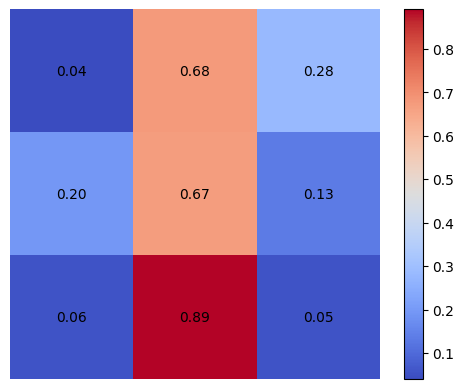

In [42]:
weights1 = torch.cat(best_model.layers[0].weights, dim=0).mean(dim=0).numpy()
weights2 = torch.cat(best_model.layers[1].weights, dim=0).mean(dim=0).numpy()
weights3 = torch.cat(best_model.layers[2].weights, dim=0).mean(dim=0).numpy()

# form a 3x3 matrix and visulize it with heatbar(green for large, blue for small)
# also annotate the values
weights = np.array([weights1, weights2, weights3])
plt.imshow(weights, cmap='coolwarm')
for i in range(3):
    for j in range(3):
        plt.text(j, i, f"{weights[i, j]:.2f}", ha='center', va='center', color='black')
plt.colorbar()
# hide axis
plt.gca().axis('off')